In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
!find . -maxdepth 1 -type f -name "torch*"
!find . -maxdepth 1 -type d -name "torch*"


✅ Loaded 169845 samples, 7 emotion classes.


Map:   0%|          | 0/135876 [00:00<?, ? examples/s]

Map:   0%|          | 0/33969 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-562763982.py:96: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.743000,0.711255,0.751833,0.754149,0.751833,0.751908
2,0.545700,0.600693,0.797080,0.801333,0.797080,0.797210
3,0.382000,0.626490,0.807383,0.808336,0.807383,0.807426



📊 Validation Metrics:
eval_loss: 0.6007
eval_accuracy: 0.7971
eval_precision: 0.8013
eval_recall: 0.7971
eval_f1: 0.7972
eval_runtime: 227.3188
eval_samples_per_second: 149.4330
eval_steps_per_second: 9.3440
epoch: 3.0000

Classification Report:

              precision    recall  f1-score   support

       anger     0.7371    0.7877    0.7616      4000
        fear     0.8228    0.8972    0.8583      4988
         joy     0.7292    0.8337    0.7780      4980
        love     0.7804    0.7527    0.7663      5826
     neutral     0.9034    0.7590    0.8249      5004
     sadness     0.8070    0.7957    0.8013      4171
    surprise     0.8208    0.7592    0.7888      5000

    accuracy                         0.7971     33969
   macro avg     0.8001    0.7979    0.7970     33969
weighted avg     0.8013    0.7971    0.7972     33969



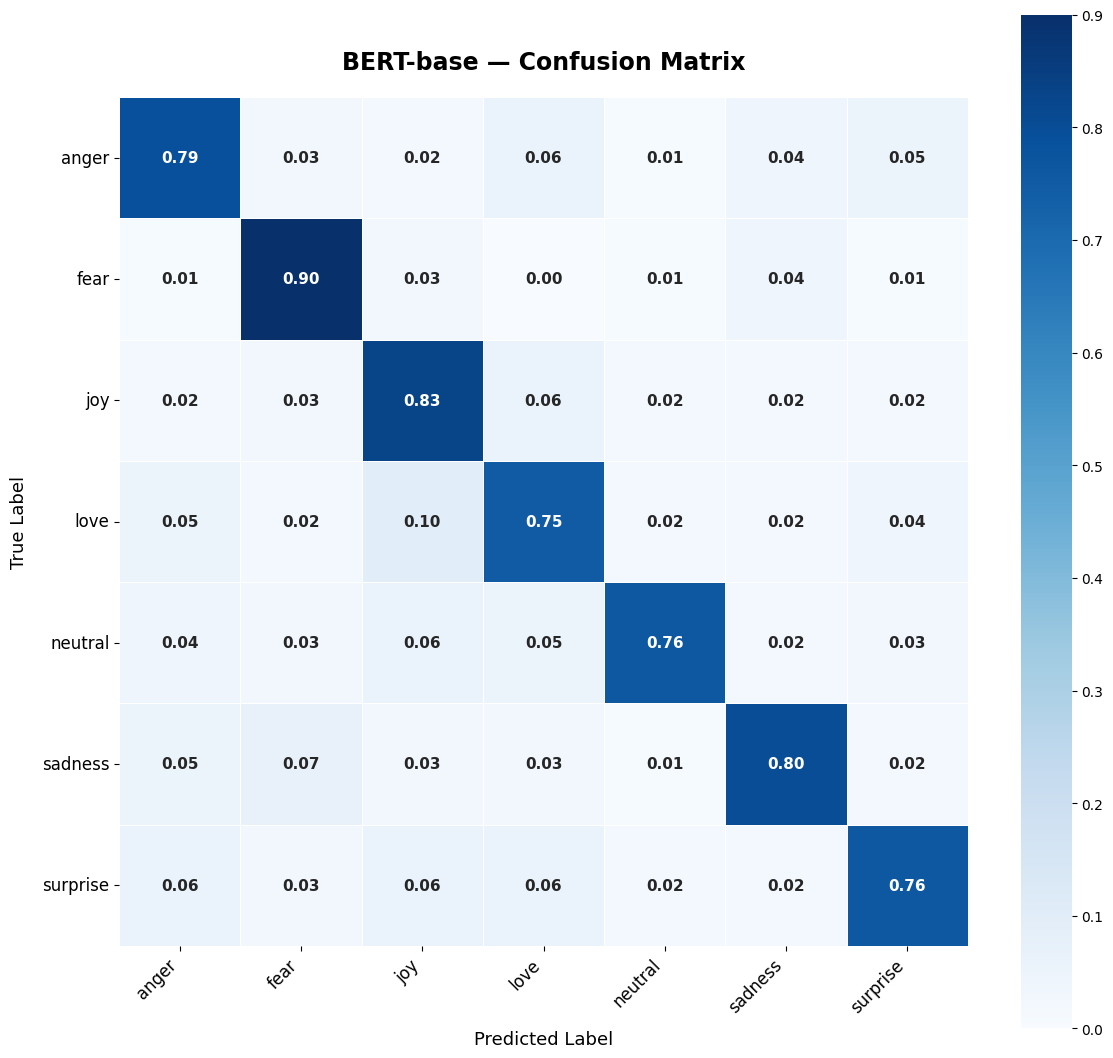

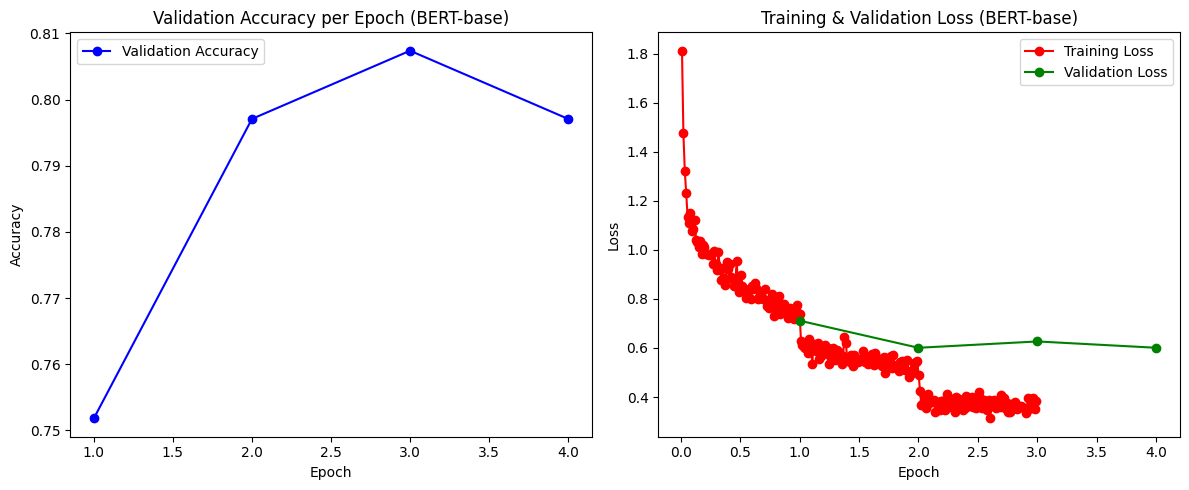


✅ BERT-base model, tokenizer, and label encoder saved successfully to /content/drive/MyDrive/sentiment_analyser


In [5]:
# ================================================================
# 🧠 MindScape Emotion Classification — BERT-base
# ================================================================

import pandas as pd
import numpy as np
import torch
import pickle
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from datasets import Dataset
from transformers import (
    BertTokenizerFast,
    BertForSequenceClassification,
    TrainingArguments,
    Trainer
)

# ================================================================
# STEP 1 — Mount Google Drive
# ================================================================

SAVE_DIR = "/content/drive/MyDrive/sentiment_analyser"
os.makedirs(SAVE_DIR, exist_ok=True)

# ================================================================
# STEP 2 — Load Dataset
# ================================================================
df = pd.read_csv("/content/balanced_emotion_dataset.csv")[['text', 'emotion']].dropna()
print(f"✅ Loaded {len(df)} samples, {df['emotion'].nunique()} emotion classes.")

le = LabelEncoder()
df['label'] = le.fit_transform(df['emotion'])
num_labels = len(le.classes_)

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# ================================================================
# STEP 3 — Tokenization
# ================================================================
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding='max_length', max_length=128)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# ================================================================
# STEP 4 — Load Model
# ================================================================
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)

# ================================================================
# STEP 5 — Metrics Function
# ================================================================
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted', zero_division=0)
    return {'accuracy': acc, 'precision': precision, 'recall': recall, 'f1': f1}

# ================================================================
# STEP 6 — Training Arguments
# ================================================================
training_args = TrainingArguments(
    output_dir="./results_bert_base",
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    logging_dir="./logs_bert_base",
    logging_steps=100,
    report_to="none"
)

# ================================================================
# STEP 7 — Trainer Setup
# ================================================================
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# ================================================================
# STEP 8 — Train Model
# ================================================================
trainer.train()

# ================================================================
# STEP 9 — Evaluate Model
# ================================================================
metrics = trainer.evaluate()
print("\n📊 Validation Metrics:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

predictions = trainer.predict(test_dataset)
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=le.classes_, digits=4))

# ================================================================
# STEP 10 — Confusion Matrix
# ================================================================
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix_final(y_true, y_pred, labels, model_name):
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    cm_display = np.round(cm, 2)

    plt.figure(figsize=(12, 11))
    sns.heatmap(
        cm_display,
        annot=True,
        fmt=".2f",
        cmap="Blues",
        cbar=True,
        xticklabels=labels,
        yticklabels=labels,
        linewidths=0.5,
        linecolor='white',
        square=True,
        annot_kws={"size": 11, "weight": "bold"}
    )

    plt.title(f"{model_name} — Confusion Matrix", fontsize=17, fontweight='bold', pad=20)
    plt.xlabel("Predicted Label", fontsize=13, labelpad=10)
    plt.ylabel("True Label", fontsize=13, labelpad=10)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(rotation=0, fontsize=12)
    plt.tight_layout()
    plt.show()

plot_confusion_matrix_final(y_true, y_pred, le.classes_, model_name="BERT-base")

# ================================================================
# STEP 11 — Accuracy & Loss Graphs
# ================================================================
logs = trainer.state.log_history
train_loss, eval_loss, eval_acc = [], [], []
epochs = []

for log in logs:
    if "loss" in log and "epoch" in log:
        train_loss.append(log["loss"])
        epochs.append(log["epoch"])
    if "eval_loss" in log:
        eval_loss.append(log["eval_loss"])
        eval_acc.append(log["eval_accuracy"])

plt.figure(figsize=(12, 5))

# Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(range(1, len(eval_acc) + 1), eval_acc, marker='o', label='Validation Accuracy', color='blue')
plt.title("Validation Accuracy per Epoch (BERT-base)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Training vs Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, marker='o', label='Training Loss', color='red')
plt.plot(range(1, len(eval_loss) + 1), eval_loss, marker='o', label='Validation Loss', color='green')
plt.title("Training & Validation Loss (BERT-base)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

# ================================================================
# STEP 12 — Save Model, Tokenizer, LabelEncoder
# ================================================================
model.save_pretrained(f"{SAVE_DIR}/BERT_base_MindScape")
tokenizer.save_pretrained(f"{SAVE_DIR}/BERT_base_MindScape")
with open(f"{SAVE_DIR}/BERT_label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)

print(f"\n✅ BERT-base model, tokenizer, and label encoder saved successfully to {SAVE_DIR}")


In [ ]:
# ================================================================
# 🔮 MindScape — Real-Time Emotion Prediction (BERT-base)
# ================================================================

import torch
import pickle
import numpy as np
import pandas as pd
from transformers import BertTokenizerFast, BertForSequenceClassification
import torch.nn.functional as F

# ---------------------------
# STEP 1 — Load Saved Model + Tokenizer + LabelEncoder
# ---------------------------
SAVE_DIR = "/content/drive/MyDrive/sentiment_analyser/BERT_base_MindScape"

tokenizer = BertTokenizerFast.from_pretrained(SAVE_DIR)
model = BertForSequenceClassification.from_pretrained(SAVE_DIR)
with open("/content/drive/MyDrive/sentiment_analyser/BERT_label_encoder.pkl", "rb") as f:
    le = pickle.load(f)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# ---------------------------
# STEP 2 — Single Prediction Function
# ---------------------------
def predict_emotion(text: str):
    """Predict the emotion of a single text."""
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=128
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        probs = F.softmax(outputs.logits, dim=-1)
        pred_idx = torch.argmax(probs, dim=-1).item()

    emotion = le.inverse_transform([pred_idx])[0]
    confidence = probs[0][pred_idx].item()

    print(f"\n🗣️ Input: {text}")
    print(f"💫 Predicted Emotion: **{emotion}**  (Confidence: {confidence:.3f})")

    return emotion, confidence

# ---------------------------
# STEP 3 — Batch Prediction Function
# ---------------------------
def predict_emotions(text_list):
    """Predict emotions for a list of sentences."""
    inputs = tokenizer(
        text_list,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=128
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        probs = F.softmax(outputs.logits, dim=-1)
        pred_idx = torch.argmax(probs, dim=-1).cpu().numpy()

    emotions = le.inverse_transform(pred_idx)
    confidences = probs.cpu().numpy().max(axis=1)
    df = pd.DataFrame({
        "Text": text_list,
        "Predicted Emotion": emotions,
        "Confidence": np.round(confidences, 3)
    })
    return df

# ---------------------------
# Example Usage
# ---------------------------

# Single prediction
predict_emotion("I’m feeling hopeful and motivated today!")

# Batch prediction
texts = [
    "That’s such a touching and beautiful story.",
    "I’m really frustrated and angry right now.",
    "I feel lonely and empty lately.",
    "This made my day so much better!",
]
results = predict_emotions(texts)
print("\n📋 Batch Predictions:\n")
display(results)



🗣️ Input: I’m feeling hopeful and motivated today!
💫 Predicted Emotion: **neutral**  (Confidence: 0.697)

📋 Batch Predictions:



,Text,Predicted Emotion,Confidence
0,That’s such a touching and beautiful story.,love,0.582
1,I’m really frustrated and angry right now.,fear,0.931
2,I feel lonely and empty lately.,fear,0.968
3,This made my day so much better!,joy,0.633
